# Numerical Methods

# Lecture 7: Numerical Linear Algebra III

## Contents

## I.     Ill - Conditioned Matrices
## II.    Round Off Errors
## III.   Algorithm Stability
## IV.   Direct vs Iterative Methods
## V.    Iterative Methods - Jacobi's Method
## VI.   Iterative Methods - Gauss - Seidel Method
## VII.  Sparse Matrices
## VIII.  EXTRA: How to Guide

## Learning objectives:

* Introduce ill-conditioned matrices (via matrix norms and condition number)
* Consider direct vs iterative/indirect methods
* Example iterative algorithm: the Jacobi and Gauss-Seidel methods
* Sparse matrices and a pointer to more advanced algorithms (supplementary readings)

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy.linalg as sl

## I.     Ill-conditioned matrices

The conditioning (or lack of, i.e. the ill-conditioning) of matrices we are trying to invert (to obtain the inverse, or to find the solution to a linear matrix system) is incredibly important for the success of any algorithm.

When we started talking about matrices we noted that as long as the matrix is non-singular, i.e. $\det(A)\ne 0$, then an inverse exists, and a linear system with that $A$ has a unique solution.

But what happens when we consider a matrix that is nearly singular, i.e. $\det(A)$ is very small?

Well smallness is a relative term and so we need to ask the question of how large or small $\det(A)$ is compared to something.

That something is the *norm* of the matrix.

Basically matrices come in all shape and sizes, and their determinants come in all kinds of values. We know that a ill conditioned matrix has a determinant that is small in absolute terms, but the size of determinants is a relative thing, and we need some kind of comparison who determine what is "small" and what is "large". Thus, we can create such a reference calculating the Norms of the matrix. For now, we will explore how to find the norm, and some slides later, we will explore how does the Norm relate to the ill conditioning of the matrix. 

Note: for Norms, we are always talking in absolute terms, meaning Norms are always positive. 

Note: for Norms, we use the $||||$

#### Vector norms

Just as for vectors $\pmb{v}$ (assumed a $n\times 1$ column vector) where we have multiple possible norms to help us decide quantify the magnitude of a vector:

\begin{align}
\|\pmb{v}\|_2 & = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2} = \left(\sum_{i=1}^n v_i^2 \right)^{1/2}, &\quad{\textrm{the two-norm or Euclidean norm}}\\
\|\pmb{v}\|_1  & = |v_1| + |v_2| + \ldots + |v_n| = \sum_{i=1}^n |v_i|, &\quad{\textrm{the one-norm or taxi-cab norm}}\\
\|\pmb{v}\|_{\infty}  &= \max\{|v_1|,|v_2|, \ldots, |v_n| = \max_{i=1}^n |v_i|, &\quad{\textrm{the max-norm or infinity norm}}
\end{align}

#### Matrix norms

We can define measures of the size of matrices, e.g. for $A$ which for complete generality we will assume is of shape $m\times n$:

\begin{align}
\|A\|_F & = \left(\sum_{i=1}^m \sum_{j=1}^n A_{ij}^2 \right)^{1/2}, &\quad{\textrm{the matrix Euclidean or Frobenius norm}}\\
\|A\|_{\infty} & = \max_{i=1}^m \sum_{j=1}^n|A_{i,j}|, &\quad{\textrm{the maximum absolute row-sum norm}}\\
\end{align}

Note that while these norms give different results (in both the vector and matrix cases), they are consistent or equivalent in that they are always within a constant factor of one another (a result that is true for finite-dimensional or discrete problems as here). This means we don't really need to worry too much about which norm we're using.

Let's evaluate some examples.



In [17]:
A = np.array([[10., 2., 1.],[6., 5., 4.],[1., 4., 7.]])
print(A)

[[10.  2.  1.]
 [ 6.  5.  4.]
 [ 1.  4.  7.]]


In [18]:
print(sl.norm(A))

15.748015748023622


In [19]:
# the Frobenius norm - the default
print(sl.norm(A,'fro'))

15.748015748023622


In [20]:
# the maximum absolute row-sum
print(sl.norm(A,np.inf))

15.0


In [21]:
# the maximum absolute column-sum
print(sl.norm(A,1))

17.0


In [22]:
# the two-norm - note not the same as the Frobenius norm - also termed the spectral norm
print(sl.norm(A,2))

13.793091098640064


In [23]:
# which is defined as (!!!!)
print(np.sqrt(np.real((np.max(sl.eigvals( A.T @ A))))))

13.793091098640064


### <span style="color:blue">Exercise 7.1: matrix norms</span>

Write some code to explicitly compute the two matrix norms defined mathematically above (i.e. the Frobenius and the maximum absolute row-sum norms) and compare against the values found above using in-built scipy functions.

Also, based on the above code and comments, what is the mathematical definition of the 1-norm and the 2-norm?


### Matrix conditioning

The (ill-)conditioning of a matrix is measured with the matrix condition number:

$$\textrm{cond}(A) = \|A\|\|A^{-1}\|$$

If this is close to one then $A$ is termed well-conditioned; the value increases with the degree of ill-conditioning, reaching infinity for a singular matrix.

Let's evaluate the condition number for the matrix above.


In [9]:
A = np.array([[10., 2., 1.],[6., 5., 4.],[1., 4., 7.]])

print(A)
print(np.linalg.cond(A))  # let's use the in-built condition number function
print(sl.norm(A,2)*sl.norm(sl.inv(A),2))  # so the default condition number uses the matrix two-norm
print(np.linalg.cond(A,'fro'))
print(sl.norm(A,'fro')*sl.norm(sl.inv(A),'fro'))

[[10.  2.  1.]
 [ 6.  5.  4.]
 [ 1.  4.  7.]]
10.713371881346792
10.713371881346786
12.463616561943589
12.463616561943587


The condition number is expensive to compute, and so in practice the relative size of the determinant of the matrix can be gauged based on the magnitude of the entries of the matrix.

#### Example

We know that a singular matrix does not result in a unique solution to its corresponding linear matrix system. But what are the consequences of near-singularity (ill-conditioning)?

Consider the following example


$$
\left(
  \begin{array}{cc}
    2 & 1 \\
    2 & 1 + \epsilon  \\
  \end{array}
\right)\left(
  \begin{array}{c}
    x \\
    y \\
  \end{array}
\right) = \left(
  \begin{array}{c}
    3 \\
    0 \\
  \end{array}
\right)
$$

Clearly when $\epsilon=0$ the two columns/rows are not linear independent, and hence the determinant of this matrix is zero, the condition number is infinite, and the linear system does not have a solution (as the two equations would be telling us the contradictory information that $2x+y$ is equal to 3 and is also equal to 0).

### <span style="color:blue">Exercise 7.2: Ill-conditioned matrix</span>

For the example above, consider a range of small values for $\epsilon$ and calculate the matrix determinant and condition number.

You should find for $\epsilon=0.001$ that $\det(A)=0.002$ (i.e. quite a lot smaller than the other coefficients in the matrix) and $\textrm{cond}(A)\approx 5000$.

Using `sl.inv(A) @ b` you should also be able to compute the solution $\pmb{x}=(1501.5,-3000.)^T$.

What happens when you make a very small change to the coefficients of the matrix (e.g. set $\epsilon=0.002$)?

You should find that this change of just $0.1\%$ in one of the coefficients of the matrix results in a $100\%$ change in both components of the solution!

<span style="color:red">This is the consequence of the matrix being ill-conditioned - we should not trust the numerical solution to ill-conditioned problems.</span>

A way to see this is to recognise that computers do not perform arithmetic exactly - they necessarily have to [truncate numbers](http://www.mathwords.com/t/truncating_a_number.htm) at a certain number of significant figures, performing multiple operations with these truncated numbers can lead to an erosion of accuracy. Often this is not a problem, but these so-called [roundoff](http://mathworld.wolfram.com/RoundoffError.html) errors in algorithms generating $A$, or operating on $A$ as in Gaussian elimination, will lead to small inaccuracies in the coefficients of the matrix. Hence, in the case of ill-conditioned problems, will fall foul of the issue seen above where a very small error in an input to the algorithm led to a far larger error in an output.

## II.    Roundoff errors

Note that in this course we have largely ignored the limitations of the floating point arithmetic performed by computers, including round-off errors.  

This is often the topic of the first lecture of courses, or first chapter of books, on Numerical Methods or Numerical Analysis - do take a look at some examples if you are interested.  

Also take a look at *D. Goldberg 1991: What every computer scientist should know about floating-point arithmetic, ACM Computing Surveys 23, Pages 5-48*.

For some examples of catastrophic failures due to round off errors see <https://www.ma.utexas.edu/users/arbogast/misc/disasters.html> and <a href="https://profs.info.uaic.ro/~ancai/CN/bibliografie/CN_disasters.htm">Prof. Kees Vuik page link updated since previous one had access restriction</a> and [the sinking of the Sleipner A offshore platform](http://www.ima.umn.edu/~arnold/disasters/sleipner.html).

As an example, consider the mathematical formula

$$f(x)=(1-x)^{10}.$$

We can of course relatively easily expand this out by hand

$$f(x)=1- 10x + 45x^2 - 120x^3 + 210x^4 - 252x^5 + 210x^6 - 120x^7 + 45x^8 - 10x^9 + x^{10}.$$

Mathematically these two expressions for $f(x)$ are identical; when evaluated by a computer different operations will be performed, which (we hope) should give the same answer. For numbers $x$ away from $1$ these two expressions do return (pretty much) the same answer.  

However, for $x$ close to 1 the second expression adds and subtracts individual terms of increasing size which should largely cancel out, but they don't to sufficient accuracy due to round off errors; these errors accumulate with more and more operations, leading a loss of significance <https://en.wikipedia.org/wiki/Loss_of_significance>

In [10]:
def f1(x):
    return (1. - x)**10

def f2(x):
    return (1. - 10.*x + 45.*x**2 - 120.*x**3 +
           210.*x**4 - 252.*x**5 + 210.*x**6 -
           120.*x**7 + 45.*x**8 - 10.*x**9 + x**10)

x=0.6
print(f1(x),f2(x),1.-f1(x)/f2(x)) # values computed in different ways and their relative difference
x=0.8
print(f1(x),f2(x),1.-f1(x)/f2(x)) 
x=0.95
print(f1(x),f2(x),1.-f1(x)/f2(x)) 

0.00010485760000000006 0.00010485760000436464 4.1623815505431594e-11
1.0239999999999978e-07 1.0240001356576212e-07 1.3247813024364063e-07
9.765625000000086e-14 1.2378986724570495e-13 0.21111273343425307


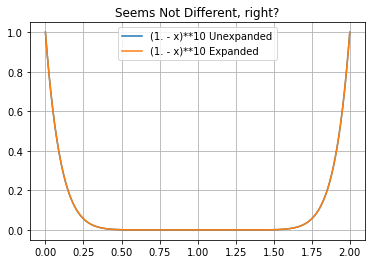

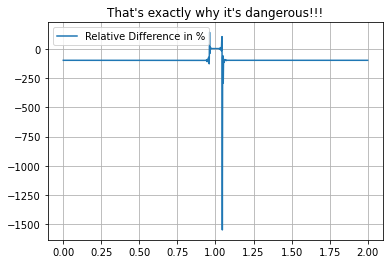

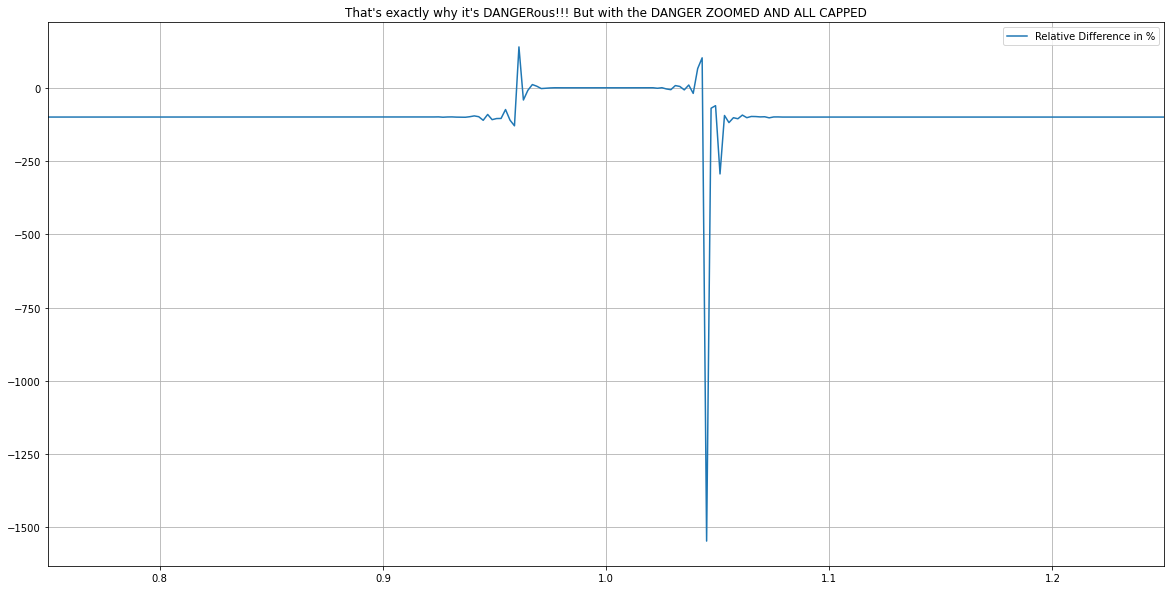

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def f1(x):
    return (1. - x)**10

def f2(x):
    return (1. - 10.*x + 45.*x**2 - 120.*x**3 +
           210.*x**4 - 252.*x**5 + 210.*x**6 -
           120.*x**7 + 45.*x**8 - 10.*x**9 + x**10)

xi = np.linspace(0, 2, 1000)
plt.plot(xi, f1(xi), label = "(1. - x)**10 Unexpanded")
plt.plot(xi, f2(xi), label = "(1. - x)**10 Expanded")
plt.grid("True")
plt.title("Seems Not Different, right?")
plt.legend()
plt.show()
plt.close()

plt.plot(xi, 1. -f1(xi)/f2(xi) * 100, label="Relative Difference in %")
plt.grid("True")
plt.title("That's exactly why it's dangerous!!!")
plt.legend()
plt.show()
plt.close()

## Zoomed in Plot
plt.figure(figsize=(20, 10))
plt.xlim(0.75, 1.25)
plt.plot(xi, 1. -f1(xi)/f2(xi) * 100, label="Relative Difference in %")
plt.grid("True")
plt.title("That's exactly why it's DANGERous!!! But with the DANGER ZOOMED AND ALL CAPPED")
plt.legend()
plt.show()
plt.close()





## III.    Algorithm stability

<span style="color:red">The susceptibility for a numerical algorithm to dampen (inevitable) errors, rather than to magnify them as we have seen in examples above, is termed *stability*.  This is a concern for numerical linear algebra as considered here, as well as for the numerical solution of differential equations as you will see in NM2.  In that case you don't want small errors to grow and accumulate as you propagate the solution to an ODE or PDE forward in time say.</span>

<span style="color:red">If your algorithm is not inherently stable, or has other limitation, you need to understand and appreciate this, as it can cause catastrophic failures!</span> 


## IV.    Direct vs Iterative Methods

Two types/families of methods exist to solve matrix systems.  These are termed *direct* methods and *iterative* (or *indirect*) methods.

Direct methods perform operations on the linear equations (the matrix system), e.g. the substitution of one equation into another which we performed two weeks ago for your example $2\times 2$ system considered in MM1. This (and the subsequent Gaussian elimination algorithm) transformed the equations making up the linear system into equivalent ones with the aim of eliminating unknowns from some of the equations and hence allowing for easy solution through back (or forward) substitution.

Also, in MM1 you (may have) learnt Cramer's rule which gives an explicit formula for the inverse of a matrix, or for the solution of a linear matrix system.  It was pointed out that the computational cost (in terms of arithmetic operations required; also termed complexity) scaled like $(n+1)!$, whereas the Gaussian elimination method (which is basically the substitution method descrined above, and implemented over the previous two lectures) scaled like $n^3$.  For large $n$ Gaussian elimination will clearly be more efficient - you considered the case where $n=100$ in MM1 for example. $n$ here refers to the number of unknowns or equations, or sometimes termed the *degrees of freedom* of the problem.

An advantage of direct methods is that they provide the exact solution (assuming exact arithmetic, i.e. ignoring the round off related issues mentioned above) in a finite number of operations.

However, as pointed out previously, $n$ could be billions for hard-core applications such as in numerical weather forecasting. In this case the $n^3$ operations required of a direct algorithm such as Gaussian elimination is completely prohibitive. In an attempt to further reduce this cost *iterative* algorithms were devised.

These algorithms start with an initial guess at the solution ($\pmb{x}_0$), and *iteratively* improve this producing a series of approximate answers $\pmb{x}_k$. For the *exact* answer to the matrix system $A\pmb{x} = \pmb{b}$, we know that the residual vector $\pmb{r} = A\pmb{x}-\pmb{b}$ is zero. For our iterative procedure, we can use the norm of the residual vector $\pmb{r}_k = A\pmb{x}_k-\pmb{b}$ based on the approximate solution $\pmb{x}_k$, as a measure of how close we are to solving the equation (the norm $\|\pmb{r}_k\|$ expresses this as a single number). As we iterate further, we hope to drive down this number and we may stop the iterations at some small (non-zero) residual norm tolerance level. The final iteration gives us an answer $\pmb{x}_k$ which is still an approximation to the solution and not the exact solution we would obtain with direct methods.  The residual norm tolerance stopping criteria therefore needs to be thought about carefully, e.g. depending on how accurate a solution $\pmb{x}$ we require.

Since well through iterative methods, $\pmb{x}_k$ is still very much an approximation rather than an exact answer, you could imagine why weather forecasting, which uses iterative methods, is still very much an approximation rather than an exact answer. However, our current exact methods are prohibitively expensive in terms of time taken, so iterative method is the best we have. You could imagine why weather forecasting is very strict on time. For large agricultural farms which use remote sensing for weather monitoring and forecast, it would be useless to tell them the exact solution to a storm a long time after the storm has passed and devastated the crop production because you tried to solve the equations involved exactly, and from the time the storm was on the horizon it took you such a long time to find the exact solution, assuming that such an exact solution even exist in the 1st place. Our most powerful supercomputers are needed for weather forecasting even if we used iterative methods, and many of us in the department will still find the computational power insufficient to tackle some of the problems at hand.

We have already considered Gaussian elimination (and back substitution) as examples of direct solution methods. We'll consider an example of an iterative method now.

## V.    Iterative methods - Jacobi's method

Consider our matrix system

$$A\pmb{x}=\pmb{b} \quad \iff \quad \sum_{j=1}^nA_{ij}x_j=b_i,\quad \textrm{for}\quad i=1,2,\ldots, n.$$

Let's rewrite this by pulling out the term involving $x_i$ (i.e. for each row $i$ pull out the diagonal from the summation):

$$A_{ii}x_i + \sum_{\substack{j=1\\ j\ne i}}^nA_{ij}x_j=b_i,\quad  i=1,2,\ldots, n.$$

We can then come up with a formula for our unknown $x_i$:

$$x_i = \frac{1}{A_{ii}}\left(b_i- \sum_{\substack{j=1\\ j\ne i}}^nA_{ij}x_j\right),\quad  i=1,2,\ldots, n.$$

Now of course for each individual $x_i$, all the other components of $\pmb{x}$ appearing on the RHS are also unknown and so this is an example of an implicit formula which doesn't help us directly, but does suggest the following iterative scheme:


* Starting from a guess at the solution $\pmb{x}^{(0)}$



* iterate for $k>0$
$$x_i^{(k)} = \frac{1}{A_{ii}}\left(b_i- \sum_{\substack{j=1\\ j\ne i}}^nA_{ij}x_j^{(k-1)}\right),\quad  i=1,2,\ldots, n.$$


Note that for this iteration, for a fixed $k$, it does not matter in which order we perform the operations over $i$ as the right hand side only contains the entries of $\pmb{x}$ at the previous iteration.

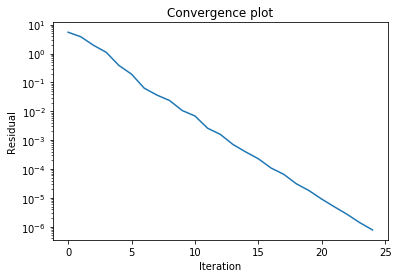

[-0.16340811 -0.01532703  0.27335262  0.36893551]
[-0.16340816 -0.01532706  0.27335264  0.36893555]


In [11]:
A = np.array([[10., 2., 3., 5.],[1., 14., 6., 2.],[-1., 4., 16., -4],[5. ,4. ,3. ,11. ]])
b = np.array([1., 2., 3., 4.])

# an initial guess at the solution - here just a vector of zeros of length the number of rows in A
x = np.zeros(A.shape[0]) 

tol = 1.e-6 # iteration tolerance
it_max = 1000 # upper limit on iterations if we don't hit tolerance
residuals=[] # store residuals

for it in range(it_max):
    x_new = np.zeros(A.shape[0])  # initialise the new solution vector
    for i in range(A.shape[0]):
        x_new[i] = (1./A[i, i]) * (b[i] - np.dot(A[i, :i], x[:i]) 
                                   - np.dot(A[i, i + 1:], x[i + 1:]))

    residual = sl.norm(A @ x - b)  # calculate the norm of the residual r=Ax-b for this latest guess
    residuals.append(residual) # store it for later plotting
    if (residual < tol): # if less than our required tolerance jump out of the iteration and end.
        break

    x = x_new # update old solution

# plot the log of the residual against iteration number 
fig = plt.figure(figsize=(6, 4))
ax1 = plt.subplot(111)
ax1.semilogy(residuals) # plot the log of the residual against iteration number 
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Residual')
ax1.set_title('Convergence plot')
plt.show()

print(x_new) # our solution vector
print(sl.inv(A) @ b)  # check against scipy

## VI.    Iterative methods - Gauss-Seidel's method

We can make a small improvement to Jacobi's method using the updated components of the solution vector as soon as they become available:


* Starting from a guess at the solution $\pmb{x}^{(0)}$



* iterate for $k>0$
$$x_i^{(k)} = \frac{1}{A_{ii}}\left(b_i- \sum_{\substack{j=1\\ j< i}}^nA_{ij}x_j^{(k)} - \sum_{\substack{j=1\\ j> i}}^nA_{ij}x_j^{(k-1)}\right),\quad  i=1,2,\ldots, n.$$

Note that as opposed to Jacobi, we can overwrite the entries of $\pmb{x}$ as they are updated, with Jacobi we need to store both the new as well as the old iteration (i.e. not overwrite the old entries until we have finished with them - which was not until the end of every iteration).

As we are using updated knowledge immediately, the Gauss-Seidel algorithm should converge faster than Jacobi, but note that this convergence can only be *guaranteed* for matrices which are diagonally dominant (for every row, the magnitude of value on the main diagonal is greater than the sum of the magnitudes of all the other entries in that row), or if the matrix is *symmetric positive definite* (a property we won't define in this course).  



### <span style="color:blue">Exercise 7.3: Implement Gauss-Seidel's method.</span>

Generalise the Jacobi code to solve the matrix problem using Gauss-Seidel's method.

## VIII.    Sparse matrices

Note that the matrices which result from the numerical solution of differential equations are generally  *sparse* (<https://en.wikipedia.org/wiki/Sparse_matrix>) which means that most entries are zero (the alternative is termed *dense*).  Knowing which entries are zero means that we can devise more efficient matrix storage methods, as well as more efficient implementations of the above algorithms (e.g. by not bothering to do operations that we know involve multiplications by zero - we know the answer will be zero).

As an example, for the two iterative methods shown above (Jacobi and Gauss Seidel), the cost of *each* iteration is quadratically dependent on the number of unknowns $n$, since we need to loop through all the entries of the $n\times n$ matrix $A$. For a fixed number of iterations the computational cost of these methods therefore scales as $n^2$. If we know that each row only contains a fixed, small number of non-zero entries however (as for example the matrix in the example below), we can simply skip the zero entries and the cost *per iteration* becomes linear in $n$. These scalings of $n^2$ for *dense* and $n$ for *sparse* matrices for the cost per iteration are typical for iterative methods. Unfortunately this does not mean that the overall cost of an iterative method is also $n^2$ or $n$, as the number of iterations that is needed to achieve a certain accuracy quite often also increases for larger problem sizes. The number of required iterations typically only increases very slowly however, so that the cost of the method is still considerably cheaper than direct methods, in particular for very large problems.

A huge range of iterative solution methods exist and the literature on this topic is massive. Below is an example of using scipy to access the Conjugate Gradient algorithm which is a popular example of a method suitable for matrices which result from the numerical solution of differential equations.

In [12]:
import scipy.sparse.linalg

n = 50
main_diag = np.ones(n)   #just a vector of ones
off_diag = np.random.random(n-1)  # to make it a bit more interesting make the off-diagonals random
A = np.diag(-2*main_diag,0) + np.diag(1.*off_diag,1) + np.diag(1.*off_diag,-1)
# A random RHS vector
b = np.random.random(A.shape[0])

print(A) # print our A in "dense" matrix format

sA = scipy.sparse.csr_matrix(A) # The same matrix in a "sparse" matrix data structure where only non-zeros stored
print('This is the same matrix but now stored in a sparse matrix data structure.')
print(sA)

# now use a scipy iterative algorithm (Conjugate Gradient) to solve

# First define a (callback) function which we are allowed to pass to the solver; here this is coded such that it will store and print the iteration numbers and residuals - basically a method to output some diagnostic information on the solver as it executes
def gen_callback_cg():
    diagnostics = dict(it=0, residuals=[]) 
    def callback(xk):   # xk is the solution computed by CG at each iteration
        diagnostics["it"] += 1
        diagnostics["residuals"].append(sl.norm(A @ xk - b))
        print(diagnostics["it"], sl.norm(A @ xk - b))
    return callback    

print('Now we execute the CG algorithm on our problem, with our callback function returning information on the residual at each iteration.')
x_sol = scipy.sparse.linalg.cg(A,b,x0=None, tol=1e-10, maxiter=1000, callback=gen_callback_cg())

[[-2.          0.01579799  0.         ...  0.          0.
   0.        ]
 [ 0.01579799 -2.          0.96907927 ...  0.          0.
   0.        ]
 [ 0.          0.96907927 -2.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -2.          0.293628
   0.        ]
 [ 0.          0.          0.         ...  0.293628   -2.
   0.02000908]
 [ 0.          0.          0.         ...  0.          0.02000908
  -2.        ]]
This is the same matrix but now stored in a sparse matrix data structure.
  (0, 0)	-2.0
  (0, 1)	0.01579798887096051
  (1, 0)	0.01579798887096051
  (1, 1)	-2.0
  (1, 2)	0.9690792657586554
  (2, 1)	0.9690792657586554
  (2, 2)	-2.0
  (2, 3)	0.4426848628892317
  (3, 2)	0.4426848628892317
  (3, 3)	-2.0
  (3, 4)	0.33287797242853423
  (4, 3)	0.33287797242853423
  (4, 4)	-2.0
  (4, 5)	0.8349961890669807
  (5, 4)	0.8349961890669807
  (5, 5)	-2.0
  (5, 6)	0.2759243129018931
  (6, 5)	0.2759243129018931
  (6, 6)	-2.0
  (6, 7)	0.5899642313423469
  

## An example of a sparse matrix

Let us consider an electric circuit arranged in a regular grid of $n$ rows and $m$ columns. The nodes in the grid are numbered from 0 to $nm-1$ as indicated in the diagram below.

![bla](images/circuit.png)

We want to calculate the electric potential $V_i$ in all of the nodes $i$. A node $i$ somewhere in the middle of the circuit is connected via resistor to nodes $i-1$ and $i+1$ to the left and right respectively, and to the nodes $i-m$ and $i+m$ in the rows above and below. For simplicity we assume that all resistors have the same resistance value $R$. The first and last node of the circuit (0 and $nm-1$) to a battery via two additional resistors, with the same resistance value $R$.

The sum of the currents coming into a node is zero (if we use a sign convention where a current coming into a node is positive and a current going out is negative. The currents between two nodes can be calculated using Ohm's law: $I=V/R$ where $R$ is the resistance of the resistor, and $V$ is the potential difference between two nodes, say $V=V_i-V_{i-1}$. Therefore we can write:

\begin{eqnarray}
  0 &=& I_{i-1\to i} + I_{i+1\to i} + I_{i-m\to i} + I_{i+m\to i} \\
    &=& V_{i-1\to i}/R + V_{i+1\to i}/R + V_{i-m\to i}/R + V_{i+m\to i}/R \\
    &=& (V_{i}-V_{i-1})/R + (V_{i}-V_{i+1})/R + (V_{i}-V_{i-m})/R + (V_{i}-V_{i+m})/R \\
    &=& (4V_{i}-V_{i-1}-V_{i+1}-V_{i-m}-V_{i+m})/R
\end{eqnarray}

This gives us one linear equation for each node in the circuit (with slight modifications for nodes that are not in the interior). These can be combined into a linear system $Ax=b$ which is assembled in the code below:

In [13]:
n = 4 # number of rows
m = 3 # number of columns
V_battery = 5.0 # voltage on the right of the battery

A = np.zeros((n*m, n*m))
for row in range(n):
    for column in range(m):
        i = row*m + column # node number
        if column>0: # left neighbour
            A[i,i-1] += -1.0
            A[i,i] += 1.0
        if column<m-1: # right neighbour
            A[i,i+1] += -1.0
            A[i,i] += 1.0
        if row>0: # neighbour above
            A[i,i-m] += -1.0
            A[i,i] += 1.0
        if row<n-1: # neighbour below
            A[i,i+m] += -1.0
            A[i,i] += 1.0

# connecting node 0 to the battery: I = (V_0 - 0)/R
A[0,0] += 1.0 
# connecting last node nm-1 to the battery: I = (V_0 - V_battery)/R = V_0/R - V_battery/R
A[n*m-1,n*m-1] += 1.0
# the V_battery/R term is a constant that does not depend on the unknowns, so ends up in the rhs vector b
b = np.zeros(n*m)
b[n*m-1] = V_battery
print(A)

[[ 3. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  3. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  3. -1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0. -1.  4. -1.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  3.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  3. -1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  4. -1.  0. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  3.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  3. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  3.]]


## EXTRA.    How - to - Guide

Always check the solvability before actually trying to solve it! You could use determinant and Norms, or the Gaussian - Jordan to check!

For system of linear equations

- If the problem you are solving has very few unknowns and very few equations, i.e. 3 or less, maybe more for some of you who are more math savvy, then solve it by hand

- If the problem you are solving has few unknowns and few equations, use Gaussian Elimination, preferably through LU decomposition using Doolittle Algorithm and maybe implement partial pivoting for $0$ on the diagonal

- f the problem you are solving has lots of unknowns and lots of equation, and finding the exact solution would take ages, and well you don't have ages of time to solve the problem, then preferably Iterative Methods, such as the Jacobi Method or Gauss - Seidel Method. 

For numerical solutions to differential equations that are generally sparse - maybe use Conjugate Gradient Algorithm or some other algorithm that reduces the number of operations for sparse matrices, especially for very large sparse matrices. 